# Decode Features of Card Selections with Spiking Data

### Imports

In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression

species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 1500

feature_dims = ["Color", "Shape", "Pattern"]

### Fetch Data from S3, FileSystem

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   


In [3]:
feature_selections = pd.read_pickle(fs.open("l2l.pqz317.scratch/feature_selections.pickle"))
firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}.pickle"))

### Define helper function

In [4]:
def create_fig_by_splitter(feature_dim, splitter, splitter_name, clf_type, clf, inputs, labels):
    _, test_accs_by_bin, shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
        clf, inputs, labels, np.arange(0, 2.8, 0.1), splitter
    )
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_{clf_type}_accs_{pre_interval}_fb_{post_interval}_by_bin_{splitter_name}_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_{clf_type}_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_{splitter_name}_split.npy", "wb"), shuffled_accs)

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        "Test Acc"
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        "Shufled Acc"
    )
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()


Feature dim Color
Generating figs for Random Splitter
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


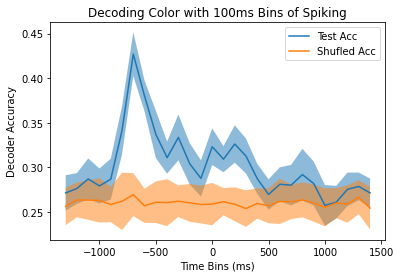

In [5]:
for feature_dim in ["Color"]:
    print(f"Feature dim {feature_dim}")
    clf = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial')
    # Look at Spike Counts instead of Firing Rate
    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    print(f"Generating figs for Random Splitter")
    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)
    create_fig_by_splitter(feature_dim, random_splitter, "random", "svm", clf, inputs, labels)